In [1]:
import nltk
from nltk.corpus import stopwords
import nltk.data
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import zeros
import os
import re
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
import itertools
nltk.download('averaged_perceptron_tagger')
# import sys 
# reload(sys)
# sys.setdefaultencoding("gbk")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gjx/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Define some useful function for the next steps

In [2]:
def keyFunc(afilename):
    #A key function used to sort the file list
    m = re.search('(?<=Episode)\d{2}', afilename)
    return m.group(0)

def untokenize(words):
    """
    Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    #ref : https://github.com/commonsense/metanl/blob/master/metanl/token_utils.py
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .', '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
        "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

def get_frequent_word(tfidf, episod):
    X = tfidf.transform([episod])
    tfidf_table = X.todense().tolist()[0]
    frequent_word = []
    candidate_number = 20
    for word in sorted(zip(tfidf_table,tfidf.get_feature_names()), reverse=True)[:candidate_number]:
        frequent_word.append(word[1])
    return frequent_word

def make_sentence (untokenized):
    #ref :https://github.com/thavelick/summarize/blob/master/summarize.py
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    normal_sentences = sent_detector.tokenize(untokenized) 
    working_sentences = [sentence.lower() for sentence in normal_sentences]
    return working_sentences, normal_sentences


def get_output_sentence(most_frequent_words, working_sentences, normal_sentences, num_phrase):
    temp_sentences = []
    output_sentences = []
    #extract all sentence with high frequent word
    for word in most_frequent_words:
        for i in range(len(working_sentences)):
            if (word in working_sentences[i] and normal_sentences[i] not in temp_sentences):
                temp_sentences.append(normal_sentences[i]) 
    #class the sentences
    counter = zeros(len(temp_sentences))
    for i in range(len(temp_sentences)):
        for word in most_frequent_words:
            if word in temp_sentences[i]:
                counter[i]+=tags_dict[word]
        if len(temp_sentences[i])>15:
            counter[i]=counter[i]-2
    for sentence in sorted(zip(counter,temp_sentences), reverse=True)[:num_phrase]:
        output_sentences.append(sentence[1])
    return output_sentences

def reorder_sentences(output_sentences, original):
    ordered_output=[]
    for sentence in original:
        if sentence in output_sentences:
            ordered_output.append(sentence)
    return ordered_output

### Read the files and prepare the corpus for the next step

In [3]:
dir_path = './sous_titre/'
file_list = sorted(os.listdir(dir_path), key=keyFunc)
collection=[] #document collection
#sum=0
error=[]
for file in file_list:
    file_path = os.path.join(dir_path, file)
    if os.path.isfile(file_path):
        with open(file_path,"rt") as f:
            lines=f.readlines()
            episod=[]
            for x in lines:
                try:
                    #print(x.split(" ")[4])
                    episod.append(x.split(" ")[4])
                except:
                    #sum+=1
                    error.append(x)
                    continue
        collection.append(episod)
        
untokenized_collection=[]
        
for episod in range(len(collection)):
    untokenized_collection.append(untokenize(collection[episod]))

print (untokenized_collection[0])

So if a photon is directed through a plane with two slits in it and either slit is observed, it will not go through both slits. If it's unobserved it will, however, if it's observed after it's left the plane but before it hits its target, it will not have gone through both slits. Agreed, what's your point? There's no point, I just think it's a good idea for a tee-shirt. Excuse me? Hang on. One across is Aegean, eight down is Nabakov, twenty-six across is MCM, fourteen down is... move your finger... phylum, which makes fourteen across Port-au-Prince. See, Papa Doc's capital idea, that's Port-au-Prince. Haiti. Can I help you? Yes. Um, is this the High IQ sperm bank? If you have to ask, maybe you shouldn't be here. I think this is the place. Fill these out. Thank-you. We'll be right back. Oh, take your time. I'll just finish my crossword puzzle. Oh, wait. Leonard, I don't think I can do this. What, are you kidding? You're a semi-pro. No. We are committing genetic fraud. There's no guarant

In [4]:
tags_list=[]
for i in range(len(collection)):
    tags_list.extend(nltk.pos_tag(collection[i]))

tags_dict={}
#we will give a weight for noun and others, preference on noun
for tag in tags_list:
    if (tag[1]=='NN' or tag[1]=='NNP' or tag[1]=='NNS') and tag[0] not in tags_dict:
        tags_dict[tag[0]]=2
    elif tag[0] not in tags_dict:
        tags_dict[tag[0]]=1

### Read the summaries

In [5]:
dir_path = './summary/'
f_list = sorted(os.listdir(dir_path))
file_list=[]
file_list.append(f_list[0])
file_list.extend(f_list[9:])
file_list.extend(f_list[1:9])
r_collection=[] #document collection
r_error=[]
p_error=[]
#sum=0
for file in file_list:
    file_path = os.path.join(dir_path, file)
    if os.path.isfile(file_path):
        with open(file_path,"rt") as f:
            lines=f.readlines()
            episod=[]
            for x in lines:
                episod.append(x)
        r_collection.append(episod)
        
r_untokenized_collection=[]
        
for episod in range(len(r_collection)):
    try:
        r_untokenized_collection.append(untokenize(r_collection[episod]))
    except:
        r_error.append(r_collection[episod])
        p_error.append(episod)
        continue


print (r_untokenized_collection[0])
#print(sum)

After an unsuccessful visit to the high-IQ sperm bank, Dr. Leonard Hofstadter and Dr. Sheldon Cooper return home to find aspiring actress Penny is their new neighbor across the hall from their apartment. Sheldon thinks Leonard, who is immediately interested in her, is chasing a dream he will never catch. Leonard invites Penny to his and Sheldon's apartment for Indian food, where she asks to use their shower since hers is broken. While wrapped in a towel, she gets to meet their visiting friends Howard Wolowitz, a wannabe ladies' man who tries to hit on her, and Rajesh Koothrappali, who is unable to speak to her as he suffers from selective mutism in the presence of women. Leonard is so infatuated with Penny that, after helping her use their shower, he agrees to retrieve her TV from her ex-boyfriend Kurt. However, Kurt's physical superiority overwhelms Leonard's and Sheldon's combined IQ of 360, and they return without pants or TV. Penny, feeling bad, offers to take the guys out to dinne

### Calculer le tf-idf and prepare the model

In [6]:
oral_words = ['oh', 'yes', 'no', 'hi', 'okay', 'uh', 'okay', 'bye', 'sorry', 'well', 'think','know','going','yeah','hoo','aa'] #A compléter dans les tests
fault_words = ['align','dr','choo','chka','mano','800','snipe','lane'] #There are some fault world in the corpus, which will pertube our summarization
stop_words = stopwords.words('english') + list(punctuation) + oral_words + fault_words
tfidf = TfidfVectorizer(stop_words=stop_words)
tfidf.fit(untokenized_collection[episod] for episod in range(len(untokenized_collection)))
print ('Model prepared! You can make your summarize now!')

Model prepared! You can make your summarize now!


### Get the summaries automatically according to the model

In [7]:
evalution_set=[]
for episod in untokenized_collection:
    most_frequent_words = get_frequent_word(tfidf, episod)
    working_sentences, normal_sentences = make_sentence (episod)
    num_sentences = 10
    out=get_output_sentence(most_frequent_words, working_sentences, normal_sentences,num_sentences)
    sentences=reorder_sentences(out, normal_sentences)
    evalution_set.append(sentences)

### Get the references

In [8]:
reference_set=[]
for episod in r_untokenized_collection:
    reference_text=r_untokenized_collection[0]
    r1,r2=make_sentence(reference_text)
    reference_set.append(r1)

### Rouge-N model

In [9]:
def _get_ngrams(n, text):
    """
    Calcualtes n-grams.
    """
    ngram_set = set()
    text_length = len(text)
    max_index_ngram_start = text_length - n
    for i in range(max_index_ngram_start + 1):
        ngram_set.add(tuple(text[i:i + n]))
    return ngram_set

def _split_into_words(sentences):
    """
    Splits multiple sentences into words and flattens the result
    """
    return list(itertools.chain(*[_.split(" ") for _ in sentences]))
#     return sentences.split(" ")
def _get_word_ngrams(n, sentences):
    """
    Calculates word n-grams for multiple sentences.
    """
    assert len(sentences) > 0
    assert n > 0

    words = _split_into_words(sentences)    
    return _get_ngrams(n, words)

def rouge_n(evaluated_sentences, reference_sentences, n=2):
    """
    Computes ROUGE-N of two text collections of sentences.
    """
    if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
        raise ValueError("Collections must contain at least 1 sentence.")

    evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
    reference_ngrams = _get_word_ngrams(n, reference_sentences)
#     print (evaluated_ngrams)
    reference_count = len(reference_ngrams)
    evaluated_count = len(evaluated_ngrams)

    # Gets the overlapping ngrams between evaluated and reference
    overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
    overlapping_count = len(overlapping_ngrams)

    # Handle edge case. This isn't mathematically correct, but it's good enough
    if evaluated_count == 0:
        precision = 0.0
    else:
        precision = overlapping_count / evaluated_count

    if reference_count == 0:
        recall = 0.0
    else:
        recall = overlapping_count / reference_count

    f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))

    return {"Precision": precision, "Recall": recall, "F1-score": f1_score,}

In [10]:
h1="he is a good man."
r1="she is a good woman."
h1=[h1]
r1=[r1]
r_1=rouge_n(h1,r1,1)
r_2=rouge_n(h1,r1,2)
print(r_1)
print(r_2)

{u'Recall': 0.6, u'F1-score': 0.5999999950000001, u'Precision': 0.6}
{u'Recall': 0.5, u'F1-score': 0.4999999950000001, u'Precision': 0.5}


### Rouge-L model

In [11]:
def _len_lcs(x, y):
    """
    Returns the length of the Longest Common Subsequence between sequences x
    and y.
    """
    table = _lcs(x, y)
    n, m = len(x), len(y)
    return table[n, m]
def _lcs(x, y):
    """
    Computes the length of the longest common subsequence (lcs) between two
    strings. The implementation below uses a DP programming algorithm and runs
    in O(nm) time where n = len(x) and m = len(y).
    """
    n, m = len(x), len(y)
    table = dict()
    for i in range(n + 1):
        for j in range(m + 1):
            if i == 0 or j == 0:
                table[i, j] = 0
            elif x[i - 1] == y[j - 1]:
                table[i, j] = table[i - 1, j - 1] + 1
            else:
                table[i, j] = max(table[i - 1, j], table[i, j - 1])
    return table
def _recon_lcs(x, y):
    """
    Returns the Longest Subsequence between x and y.
    """
    i, j = len(x), len(y)
    table = _lcs(x, y)

    def _recon(i, j):
        """private recon calculation"""
        if i == 0 or j == 0:
            return []
        elif x[i - 1] == y[j - 1]:
            return _recon(i - 1, j - 1) + [(x[i - 1], i)]
        elif table[i - 1, j] > table[i, j - 1]:
            return _recon(i - 1, j)
        else:
            return _recon(i, j - 1)

    recon_tuple = tuple(map(lambda x: x[0], _recon(i, j)))
    return recon_tuple
def _union_lcs(evaluated_sentences, reference_sentence, prev_union=None):
    """
    Returns LCS_u(r_i, C) which is the LCS score of the union longest common
    subsequence between reference sentence ri and candidate summary C.
    """
    if prev_union is None:
        prev_union = set()

    if len(evaluated_sentences) <= 0:
        raise ValueError("Collections must contain at least 1 sentence.")

    lcs_union = prev_union
    prev_count = len(prev_union)
    reference_words = _split_into_words([reference_sentence])

    combined_lcs_length = 0
    for eval_s in evaluated_sentences:
        evaluated_words = _split_into_words([eval_s])
        lcs = set(_recon_lcs(reference_words, evaluated_words))
        combined_lcs_length += len(lcs)
        lcs_union = lcs_union.union(lcs)

    new_lcs_count = len(lcs_union) - prev_count
    return new_lcs_count, lcs_union


def rouge_l_summary_level(evaluated_sentences, reference_sentences):
    """
    Computes ROUGE-L (summary level) of two text collections of sentences.
    """
    if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
        raise ValueError("Collections must contain at least 1 sentence.")

    # total number of words in reference sentences
    m = len(set(_split_into_words(reference_sentences)))

    # total number of words in evaluated sentences
    n = len(set(_split_into_words(evaluated_sentences)))

    # print("m,n %d %d" % (m, n))
    union_lcs_sum_across_all_references = 0
    union = set()
    for ref_s in reference_sentences:
        lcs_count, union = _union_lcs(evaluated_sentences,
                                      ref_s,
                                      prev_union=union)
        union_lcs_sum_across_all_references += lcs_count

    llcs = union_lcs_sum_across_all_references
    r_lcs = llcs / m
    p_lcs = llcs / n
    beta = p_lcs / (r_lcs + 1e-12)
    num = (1 + (beta**2)) * r_lcs * p_lcs
    denom = r_lcs + ((beta**2) * p_lcs)
    f_lcs = num / (denom + 1e-12)
    return {"Precision": p_lcs, "Recall": r_lcs, "F1-score": f_lcs}

In [12]:
r_l=rouge_l_summary_level(h1,r1)
print(r_l)

{u'Recall': 0.6, u'F1-score': 0.5999999999994999, u'Precision': 0.6}


### Useful functions for getting rouge scores

In [13]:
def treat_for_rouge(evalution,reference):
    e=""
    r=""
    for i in evalution:
        e+=i
    for j in reference:
        r+=j
    e=[e]
    r=[r]
    for hyp, ref in zip(e, r):
        hyp = [" ".join(_.split()) for _ in hyp.split(".") if len(_) > 0]
        ref = [" ".join(_.split()) for _ in ref.split(".") if len(_) > 0]
    return hyp,ref

In [14]:
def score_evalution(evalution,reference):
    hyp,ref=treat_for_rouge(evalution,reference)
    return {"rouge1":rouge_n(hyp,ref,1), "rouge2":rouge_n(hyp,ref,2), "rougel":rouge_l_summary_level(hyp,ref)}

### Get the scores

In [15]:
scores=[]
for i,j in zip(evalution_set,reference_set):
    s=score_evalution(i,j)
    scores.append(s)

In [16]:
scores

[{u'rouge1': {u'F1-score': 0.11940298024405356,
   u'Precision': 0.14634146341463414,
   u'Recall': 0.10084033613445378},
  u'rouge2': {u'F1-score': 0.0, u'Precision': 0.0, u'Recall': 0.0},
  u'rougel': {u'F1-score': 0.10271952898389433,
   u'Precision': 0.13414634146341464,
   u'Recall': 0.09243697478991597}},
 {u'rouge1': {u'F1-score': 0.17241378810679267,
   u'Precision': 0.17699115044247787,
   u'Recall': 0.16806722689075632},
  u'rouge2': {u'F1-score': 0.011730200278637505,
   u'Precision': 0.011764705882352941,
   u'Recall': 0.011695906432748537},
  u'rougel': {u'F1-score': 0.12913771364662407,
   u'Precision': 0.13274336283185842,
   u'Recall': 0.12605042016806722}},
 {u'rouge1': {u'F1-score': 0.11111110611257237,
   u'Precision': 0.11304347826086956,
   u'Recall': 0.1092436974789916},
  u'rouge2': {u'F1-score': 0.0, u'Precision': 0.0, u'Recall': 0.0},
  u'rougel': {u'F1-score': 0.10250421548820432,
   u'Precision': 0.10434782608695652,
   u'Recall': 0.10084033613445378}},
 {u'r

### Show results in graphs

In [17]:
import numpy as np
import matplotlib.pyplot as plt
nrouge1_p=[]
nrouge1_r=[]
nrouge1_f=[]
nrouge2_p=[]
nrouge2_r=[]
nrouge2_f=[]
nrougel_p=[]
nrougel_r=[]
nrougel_f=[]
x=range(1,18)
for i in scores:
    nrouge1_p.append(i[u'rouge1'][u'Precision'])
    nrouge1_r.append(i[u'rouge1'][u'Recall'])
    nrouge1_f.append(i[u'rouge1'][u'F1-score'])
    nrouge2_p.append(i[u'rouge2'][u'Precision'])
    nrouge2_r.append(i[u'rouge2'][u'Recall'])
    nrouge2_f.append(i[u'rouge2'][u'F1-score'])
    nrougel_p.append(i[u'rougel'][u'Precision'])
    nrougel_r.append(i[u'rougel'][u'Recall'])
    nrougel_f.append(i[u'rougel'][u'F1-score'])

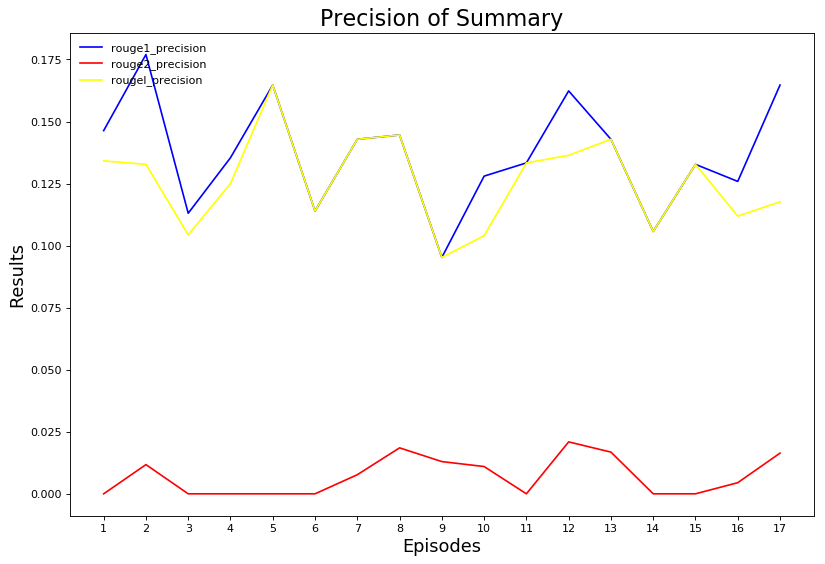

In [18]:
plt.figure(figsize=(12,8), dpi=80)
plt.title("Precision of Summary",size=20)
ticks=np.linspace(1,17,17)
plt.xticks(ticks)
plt.xlabel("Episodes",size=16)
plt.ylabel("Results",size=16)
#plt.ylim((0,0.2))
plt.plot(x, nrouge1_p, color="blue",label="rouge1_precision")
plt.plot(x, nrouge2_p, color="red",label="rouge2_precision" )
plt.plot(x, nrougel_p, color="yellow",label="rougel_precision" )
plt.legend(loc='upper left', frameon=False)
plt.show()

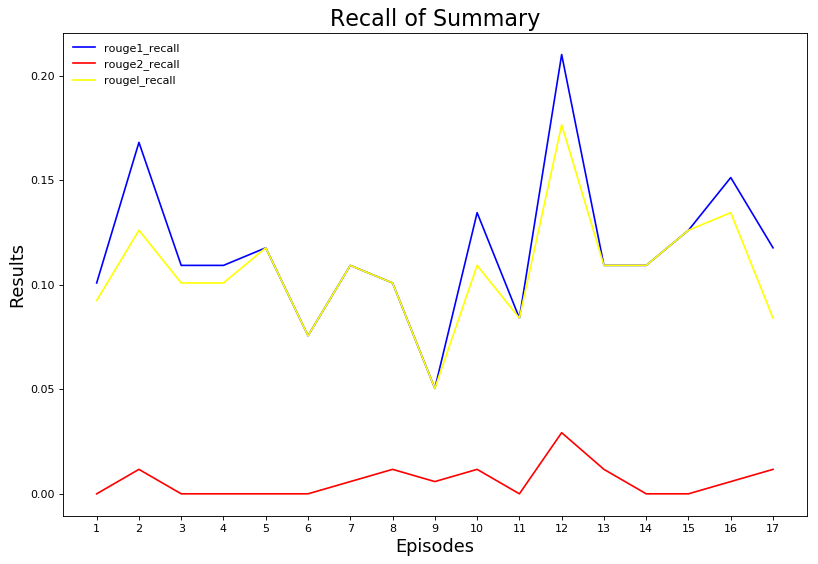

In [19]:
plt.figure(figsize=(12,8), dpi=80)
plt.title("Recall of Summary",size=20)
ticks=np.linspace(1,17,17)
plt.xticks(ticks)
plt.xlabel("Episodes",size=16)
plt.ylabel("Results",size=16)
#plt.ylim((0,0.2))
plt.plot(x, nrouge1_r, color="blue",label="rouge1_recall")
plt.plot(x, nrouge2_r, color="red",label="rouge2_recall" )
plt.plot(x, nrougel_r, color="yellow",label="rougel_recall" )
plt.legend(loc='upper left', frameon=False)
plt.savefig('./Recall')
plt.show()

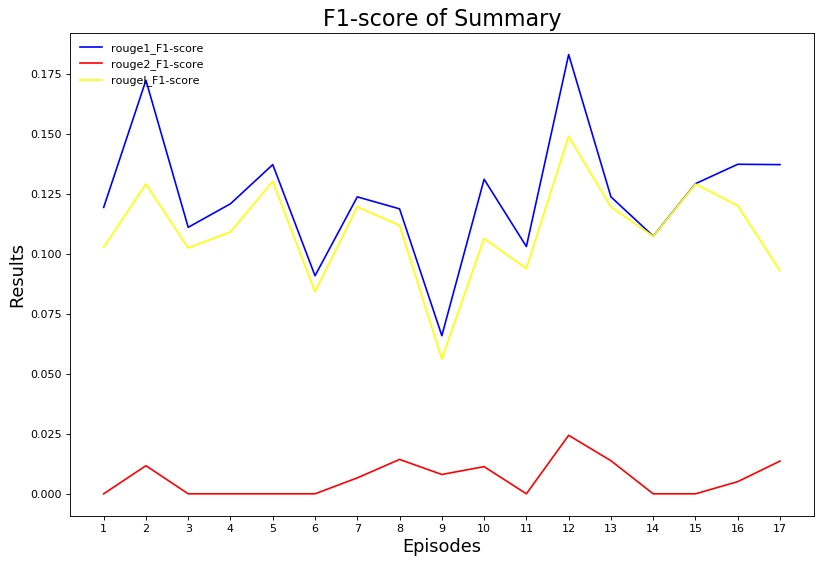

In [20]:
plt.figure(figsize=(12,8), dpi=80)
plt.title("F1-score of Summary",size=20)
ticks=np.linspace(1,17,17)
plt.xticks(ticks)
plt.xlabel("Episodes",size=16)
plt.ylabel("Results",size=16)
#plt.ylim((0,0.2))
plt.plot(x, nrouge1_f, color="blue",label="rouge1_F1-score")
plt.plot(x, nrouge2_f, color="red",label="rouge2_F1-score" )
plt.plot(x, nrougel_f, color="yellow",label="rougel_F1-score" )
plt.legend(loc='upper left', frameon=False)
plt.show()